#### NX-414: Brain-like computation and intelligence, Spring 2023

Notebook prepared by Bartlomiej Borzyszkowski

# Week 3 - Grid cells and place cells in path integration
### Table of Contents<span class="tocSkip"></span>
<div class="toc"><ul class="toc-item">
    <li><span><a href="#1.-Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1.&nbsp;&nbsp;</span>Introduction</a></span></li>
    <li><span><a href="#2.-Place-cells" data-toc-modified-id="Place-cells-2"><span class="toc-item-num">2.&nbsp;&nbsp;</span>Place cells</a></span></li>
    <li><span><a href="#3.-Trajectory-generation" data-toc-modified-id="Trajectory-generation-3"><span class="toc-item-num">3.&nbsp;&nbsp;</span>Trajectory generation</a></span></li>     
    <li><span><a href="#4.-Recurrent-Neural-Network" data-toc-modified-id="Recurrent-Neural-Network-4"><span class="toc-item-num">4.&nbsp;&nbsp;</span>Recurrent Neural Network</a></span></li>
    <li><span><a href="#5.-Train-the-model" data-toc-modified-id="Train-the-model-5"><span class="toc-item-num">5.&nbsp;&nbsp;</span>Train the model</a></span></li>  
    <li><span><a href="#6.-Evaluate-performance" data-toc-modified-id="Evaluate-performance-6"><span class="toc-item-num">6.&nbsp;&nbsp;</span>Evaluate performance</a></span></li>  
    <li><span><a href="#7.-Compute-ratemaps" data-toc-modified-id="Compute-ratemaps-7"><span class="toc-item-num">7.&nbsp;&nbsp;</span>Compute ratemaps</a></span></li>  
    <li><span><a href="#8.-Compute-grid-scores" data-toc-modified-id="Compute-grid-scores-8"><span class="toc-item-num">8.&nbsp;&nbsp;</span>Compute grid scores</a></span></li> 
    <li><span><a href="#9.-Conclusion" data-toc-modified-id="Conclusion-9"><span class="toc-item-num">9.&nbsp;&nbsp;</span>Conclusion</a></span></li>  

### 1. Introduction
Grid cells are a type of neuron within the medial entorhinal cortex (MEC) that allow to construct an internal map of space in the brain and fire in regular hexagonal patterns. Their remarkable discovery was awarded a Nobel Prize in Physiology or Medicine in 2014. There are currently two seemingly unrelated frameworks for understanding the patterns of grid cells. Mechanistic models account for hexagonal firing fields as the result of pattern-forming dynamics in a recurrent neural network. Normative models specify a neural architecture, a learning rule, and a navigational task, and observe that grid-like firing fields emerge due to the constraints of solving this task.

In this exercise, we will study a theory that combines the two frameworks by representing the learning dynamics of a neural network trained on path integration task. In particular, we will simulate an animal moving in a square box and analyze how it performs path integration.

The exercise is based on the work by [B. Sorscher et al. "A unified theory for the origin of grid cells through the lens of pattern formation", NeurIPS 2019.](https://papers.nips.cc/paper/2019/file/6e7d5d259be7bf56ed79029c4e621f44-Paper.pdf) We thank the authors for sharing their code. 

In [6]:
# import external packages
import numpy as np
import torch
import scipy
from tqdm import tqdm
from matplotlib import pyplot as plt

In [9]:
# import modules required for this problem set
from src.place_cells import PlaceCells
from src.scores import GridScorer
from src.trainer import Trainer
from src.trajectory_generator import TrajectoryGenerator
from src.utils import generate_run_ID, load_trained_weights
from src.visualize import compute_ratemaps, plot_ratemaps

First, we define the training configuration for the neural network. Please leave this part of code unchanged. After completing the exercise, you can play around with these parameters and check how they affect your results.

In [10]:
class Options:
    """ Training options and hyperparameters """
    def __init__(self):
        self.save_dir = 'models/'  # directory in which the pre-trained weights are stored
        self.n_steps = 1000        # number of training steps
        self.batch_size = 200      # number of trajectories per batch
        self.sequence_length = 20  # number of steps in trajectory
        self.learning_rate = 1e-4  # gradient descent learning rate
        self.Np = 512              # number of place cells
        self.Ng = 4096             # number of grid cells
        self.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
        self.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
        self.weight_decay = 1e-4   # strength of weight decay on recurrent weights
        self.DoG = True            # use difference of gaussians tuning curves
        self.box_width = 2.2       # width of training environment
        self.box_height = 2.2      # height of training environment
        self.device = 'cpu'        # specify a device type, i.e. 'cpu' or 'cuda'
        
options = Options()
options.run_ID = generate_run_ID(options)

### 2. Place cells
Place cells are a type of neuron that are found in the hippocampus of the brain and play a role in spatial navigation and memory. They are so named because each cell is selectively activated when an animal is in a specific location within its environment, and together they form a map of the animal's surroundings. When a place cell is activated, it generates a burst of electrical activity, which can be recorded and used to determine the location of the animal. This discovery was one of the first pieces of evidence to support the idea that the brain contains a cognitive map, or a mental representation, of the environment. Place cells are thought to be involved in various functions including memory formation, recall, and spatial navigation, and are thus of interest in understanding both normal brain function and the mechanisms underlying some forms of neurological and psychiatric disorders.



In this exercise, we simulate an animal moving in a square box (2.2m x 2.2m), and record the activity of simulated place cells tiled randomly and uniformly throughout the environment. We will collect the place cell activations at <em>$n_x$</em> locations as the animal explores its environment (Fig. 1). The place cell activations will be stored in a matrix $P \in \mathbb{R} ^ {n_x \times n_P}$.

<figure>
  <p style="text-align:center;">
  <img src="img/img1.png"
     alt="Markdown Monster icon"
     width="400" height="300"/>
  <figcaption>Fig. 1: (Left) Simulated animal trajectory; (Right) The place cell centers (dots) of the desired place code in the environment. Blue to red indicate low to high firing rates when the animal is at the location on the left.</figcaption></p>
</figure>



<br>

##### Implement a class of place cells that you will use in the followin part of the exerice.

Comple two methods for the PlaceCellsImplementation class:
1) <em>get_nearest_cell_pos</em> - should decode position of the animal using centers of its $k$ maximally active place cells;
2) <em>grid_pc</em> - should interpolate place cell outputs onto an environment size grid; 

In [12]:
class PlaceCellsImplementation(PlaceCells):
    """ Implementation of methods for Place Cells """
    
    def get_nearest_cell_pos(self, activation, k=3):
        """
        Decode position using centers of k maximally active place cells.

        Args: 
            activation: Place cell activations of shape [batch_size, sequence_length, Np].
            k: Number of maximally active place cells with which to decode position.

        Returns:
            pred_pos: Predicted 2d position with shape [batch_size, sequence_length, 2].
        """
        # TODO: get the k largest elements of the given input tensor with activations (~1 line):
        _, idxs = torch.topk(activation, k=k)
        
        pred_pos = self.us[idxs].mean(-2)
        return pred_pos

    def grid_pc(self, pc_outputs, res=32):
        """ Interpolate place cell outputs onto a grid """
        coordsx = np.linspace(-self.box_width/2, self.box_width/2, res)
        coordsy = np.linspace(-self.box_height/2, self.box_height/2, res)
        
        # TODO: Based on coordinates x and y, create a meshgrid. 
        # Specifically, create coordinate arrays from coordinate vectors (~1 line):
        grid_x, grid_y = np.meshgrid(coordsx, coordsy)
        
        grid = np.stack([grid_x.ravel(), grid_y.ravel()]).T

        # Convert to numpy
        pc_outputs = pc_outputs.reshape(-1, self.Np)

        T = pc_outputs.shape[0]
        pc = np.zeros([T, res, res])
        for i in range(len(pc_outputs)):
            gridval = scipy.interpolate.griddata(self.us.cpu(), pc_outputs[i], grid)
            pc[i] = gridval.reshape([res, res])

        return pc

place_cells = PlaceCellsImplementation(options)

### 3. Trajectory generation

Path integration refers to the process of integrating instantaneous velocity signals to obtain an estimate of current position, and is thought to be a computational function mediated by grid cells in MEC. 

As explained before, we want to simulate an animal moving in a box and analyze the activity of its simulated place cells. We use a random walk to generate example trajectories of the animal. As the animal moves, different subsets of its place cells should become active (Fig. 1 - right).

<br>

##### Run the code below to generate the trajectories and visualize them together with place cells defined before:                 

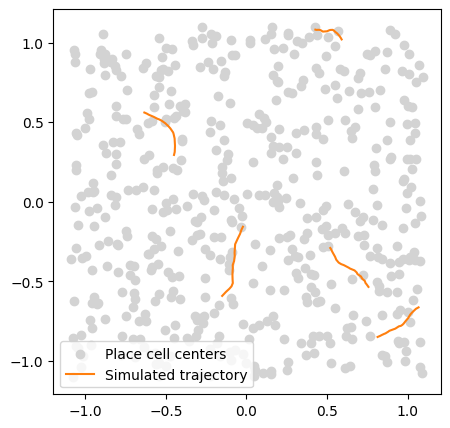

In [13]:
# Generate the trajectories as a random walk in a rectangular box
trajectory_generator = TrajectoryGenerator(options, place_cells)

# Plot a few sample trajectories
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
us = place_cells.us.cpu()
pos = pos.cpu()

plt.figure(figsize=(5,5))
plt.scatter(us[:,0], us[:,1], c='lightgrey', label='Place cell centers')
for i in range(5):
    plt.plot(pos[:,i,0],pos[:,i,1], label='Simulated trajectory', c='C1')
    if i==0:
        plt.legend();

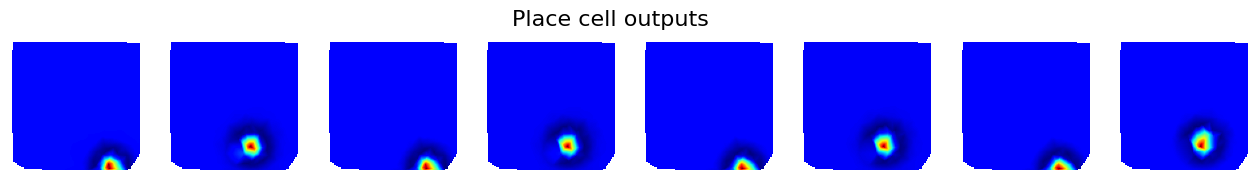

In [14]:
# Plot a few place cell outputs
pc_outputs = pc_outputs.reshape(-1, options.Np).detach().cpu()
pc = place_cells.grid_pc(pc_outputs[::100], res=100)

plt.figure(figsize=(16,2))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(pc[i], cmap='jet')
    plt.axis('off')
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

### 4. Recurrent Neural Network

We train an RNN to encode position by path integrating velocity inputs. At each time step, the network receives the animal’s 2-dimensional velocity as input. The velocity signal is integrated by the network’s recurrently connected units, and the network’s
current position representation is linearly read out into a layer of estimated place cells.

The simple RNN architecture has two key advantages: 
- the simulated grid cells are recurrently connected, like grid cells in MEC
- this architecture corresponds exactly to traditional path integrator models of grid cells known in literature



We aim to investigate if this recurrent neural network develops grid-like firing fields. We show a schematic of the position encoding objective (Fig. 2). The network should learn hidden representations <em>G</em> that convert velocity inputs to a place code <em>P</em> through a set of trained read-out weights <em>W</em>.



<figure>
  <p style="text-align:center;">
  <img src="img/img2.png"
     alt="Markdown Monster icon"
     width="500" height="600"/>
  <figcaption>Fig. 2: The model takes a velocity input which is fed to a recurrently connected
hidden unit. It generates a desired place cell output representation.</figcaption></p>
</figure>

<br>

##### Implement a vanilla RNN to encode position by path integrating velocity inputs. 
The model should consist of a single hidden layer of recurrently connected neurons with ReLU nonlinearity. Encoder and decorder should be represented as single fully-connected layers of appropriete shapes.

In [18]:
class RNN(torch.nn.Module):
    """ Implementation of the Recurrent Neural Network """
    def __init__(self, options, place_cells):
        super(RNN, self).__init__()
        self.place_cells = place_cells
            
        # TODO: define parameters of the RNN using the pre-defined options (~4 lines):
        self.Ng = options.Ng
        self.Np = options.Np
        self.sequence_length = options.sequence_length
        self.weight_decay = options.weight_decay
       
        # TODO: implement an encoder as a linear layer that takes input of place cell shape and output of grid cell shape.
        # Remark: Remember to disable an additive bias (~1 line):
        self.encoder = torch.nn.Linear(self.Np, self.Ng, bias=False)
        
        # TODO: implement a recurrent later with input_size=2, hidden_size of grid cell shape, and ReLU activation. 
        # Remark: Remember to disable an additive bias (~1 line):
        self.RNN = torch.nn.RNN(input_size=2, hidden_size=self.Ng, nonlinearity='relu', bias=False)
        
        # TODO: implement a decoder as a linear layer that takes input of grid cell shape and output of place cell shape.
        # Remark: Remember to disable an additive bias (~1 line):
        self.decoder = torch.nn.Linear(self.Ng, self.Np, bias=False)
        
        # We apply softmax output to convert a vector of numbers into a vector of probabilities
        self.softmax = torch.nn.Softmax(dim=-1)

    def g(self, inputs):
        """
        Compute grid cell activations.
        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].

        Returns: 
            g: Batch of grid cell activations with shape [batch_size, sequence_length, Ng].
        """
        v, p0 = inputs
        init_state = self.encoder(p0)[None]
        g, _ = self.RNN(v, init_state)
        return g
    
    def predict(self, inputs):
        """
        Predict place cell code.
        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].

        Returns: 
            place_preds: Predicted place cell activations with shape [batch_size, sequence_length, Np].
        """
        # TODO: Compute grid cell activations for a given input batch (~1 line):
        grid_activations = self.g(inputs)
        
        # TODO: Use decoder to predict the place cell activations based on grid activations (~1 line):
        place_preds = self.decoder(grid_activations)
        
        return place_preds

    def compute_loss(self, inputs, pc_outputs, pos):
        """
        Compute avg. loss and decoding error.
        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].
            pc_outputs: Ground truth place cell activations with shape [batch_size, sequence_length, Np].
            pos: Ground truth 2d position with shape [batch_size, sequence_length, 2].

        Returns:
            loss: Avg. loss for this training batch.
            err: Avg. decoded position error in cm.
        """
        # Compute the prediction
        y = pc_outputs
        preds = self.predict(inputs)
        yhat = self.softmax(self.predict(inputs))
        
        # TODO: compute the cross-entropy loss for the prediction and ground truth place cell activations (~1 line):
        loss = -torch.mean(y * torch.log(yhat))
        # loss = torch.nn.functional.cross_entropy(yhat, y)

        # Weight regularization 
        loss += self.weight_decay * (self.RNN.weight_hh_l0**2).sum()

        # Compute decoding error
        pred_pos = self.place_cells.get_nearest_cell_pos(preds)
        
        # TODO: compute the MSE for the predicted and ground truth positions (~1 line):
        err = torch.sqrt(torch.mean((pred_pos - pos)**2))

        return loss, err

    
model = RNN(options, place_cells).to(options.device)

### 5. Train the model
We train the “vanilla” RNN with the discrete-time dynamics:

$r_i^{t+1} = \sigma [\sum_{j=1}^{n_g} J_{ij}r_j^t + M_{ix}v_x^t + M_{iy}v_y^t]$

where:
- $r^t$ is the population activity at time $t$;
- $J$ is the $(ng, ng)$ recurrent connectivity matrix; 
- $\overrightarrow{v}^t$ is a $2$-dimensional velocity input at time $t$; 
- $M$ is the $(ng, 2)$ matrix of velocity input weights; 
- $\sigma$ is a pointwise ReLU nonlinearity. 

Predicted place cell outputs $\hat{p}^t$ are read out linearly by a $(np, ng)$ matrix of weights $W$:

$\hat{p}_i^t = \sum_{j=1}^{n_g} W_{ij}r_j^t$

Rather than tuning the weights $J, M, W$ by hand, we will train them by gradient descent on
the objective of reconstructing the true place cell outputs $p^t$ as accurately as possible. We will use a cross-entropy loss  function for this task.

<br>

##### Implement the training procedure below:

In [19]:
class TrainerImplementation(Trainer):
    """ Implementation of methods for the Trainer """
    
    def train(self, n_epochs: int = 100, n_steps=1000):
        """
        Train model on simulated trajectories.

        Args:
            n_epochs: Number of training epochs
            n_steps: Number of training steps
        """
        # Construct a trajectory generator
        traj_iterator = self.trajectory_generator.get_generator()

        # Run the training loop
        for epoch_idx in range(n_epochs):
            for step_idx in range(n_steps):
                
                # TODO: get the next item in from the trajectory iterator (~1 line):
                inputs, pc_outputs, pos = next(traj_iterator)
                
                # TODO: implement a single training step (~1 line):
                loss, err = self.train_step(inputs, pc_outputs, pos)
                
                self.loss.append(loss)
                self.err.append(err)

            print('Epoch: {}/{}. Step {}/{}. Loss: {}. Err: {}cm'.format(
                epoch_idx + 1, n_epochs, step_idx + 1, n_steps,
                np.round(loss, 2), np.round(100 * err, 2)))

    def train_step(self, inputs, pc_outputs, pos):
        """
        Train on one batch of trajectories.

        Args:
            inputs: Batch of 2d velocity inputs with shape [batch_size, sequence_length, 2].
            pc_outputs: Ground truth place cell activations with shape 
                [batch_size, sequence_length, Np].
            pos: Ground truth 2d position with shape [batch_size, sequence_length, 2].

        Returns:
            loss: Avg. loss for this training batch.
            err: Avg. decoded position error in cm.
        """
        self.model.zero_grad()

        # TODO: compute loss of the model; note that you implemented it in the RNN class (~1 line)
        loss, err = self.model.compute_loss(inputs, pc_outputs, pos)
        
        # TODO: perform backpropagation on the loss function and run a step of the optimizer (~2 lines):

        return loss.item(), err.item()

Since the training procedure is time-consuming and requires access to the GPU, we provide pre-trained weights of the neural network that can be used for evaluation purposes. We will plot the decoding error and a loss function below. If you want to change the "class Options" and train the model from scratch, remove the loading of weights.

<br>

##### Run the code below to initialize the trainer and load the pre-trained weights of the RNN:

In [20]:
# Set restore to True to load the pre-trained weights
trainer = TrainerImplementation(options, model, trajectory_generator, restore=True)
trainer.train(n_steps=options.n_steps)

plt.figure(figsize=(12,3))
plt.subplot(121)
plt.plot(trainer.err, c='black')

plt.title('Decoding error (m)'); plt.xlabel('train step')
plt.subplot(122)
plt.plot(trainer.loss, c='black');
plt.title('Loss'); plt.xlabel('train step');

Restored trained model from models/trained_model.pth
Epoch: 1/100. Step 1000/1000. Loss: 0.02. Err: 3.93cm
Epoch: 2/100. Step 1000/1000. Loss: 0.02. Err: 3.82cm
Epoch: 3/100. Step 1000/1000. Loss: 0.02. Err: 3.87cm
Epoch: 4/100. Step 1000/1000. Loss: 0.02. Err: 3.74cm


KeyboardInterrupt: 

### 6. Evaluate performance

Once the model learned how to interpret the velocity input and generate a desired place cell output representation, we will evaluate its predictions.

##### Run the code below to compare the true position of the animal to the decoded position by the neural network:

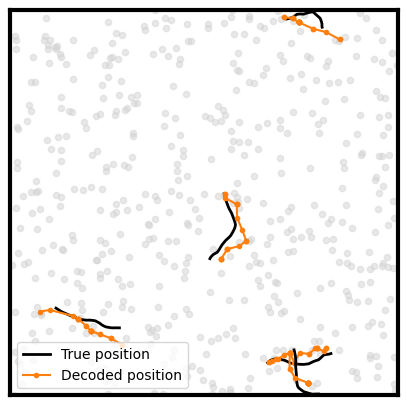

In [21]:
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
pos = pos.cpu()
pred_pos = place_cells.get_nearest_cell_pos(model.predict(inputs)).cpu()
us = place_cells.us.cpu()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
for i in range(5):
    plt.plot(pos[:,i,0], pos[:,i,1], c='black', label='True position', linewidth=2)
    plt.plot(pred_pos[:,i,0], pred_pos[:,i,1], '.-',
             c='C1', label='Decoded position')
    if i==0:
        plt.legend()
plt.scatter(us[:,0], us[:,1], s=20, alpha=0.5, c='lightgrey')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
plt.xticks([])
plt.yticks([])
plt.xlim([-options.box_width/2,options.box_width/2])
plt.ylim([-options.box_height/2,options.box_height/2]);

##### Run the code below to compare the true place cell outputs to estimated place cell outputs:

In [ ]:
inputs, pos, pc_outputs = trajectory_generator.get_test_batch()
preds = model.predict(inputs)
preds = preds.reshape(-1, options.Np).detach().cpu()
pc_outputs = model.softmax(pc_outputs).reshape(-1, options.Np).cpu()
pc_pred = place_cells.grid_pc(preds[:100])
pc = place_cells.grid_pc(pc_outputs[:100])

plt.figure(figsize=(16,4))
for i in range(8):
    plt.subplot(2,8,i+9)
    plt.imshow(pc_pred[2*i], cmap='jet')
    if i==0:
        plt.ylabel('Predicted')
    plt.axis('off')
    
for i in range(8):
    plt.subplot(2,8,i+1)
    plt.imshow(pc[2*i], cmap='jet', interpolation='gaussian')
    if i==0:
        plt.ylabel('True')
    plt.axis('off')
    
plt.suptitle('Place cell outputs', fontsize=16)
plt.show()

### 7. Compute ratemaps

We will compute a spatial ratemap for each neuron by binning the agent’s position into 2cm× 2cm bins, and computing the average firing rate within each bin.

##### Run the code below to compute and plot the ratemaps:

In [ ]:
res = 50
n_avg = 100
Ng = options.Ng
activations, rate_map, g, pos = compute_ratemaps(model,
                                                 trajectory_generator,
                                                 options,
                                                 res=res,
                                                 n_avg=n_avg,
                                                 Ng=Ng)

# Compute a set of lo-res maps to use for evalutaing grid score
lo_res = 20
_, rate_map_lores, _, _ = compute_ratemaps(model,
                                         trajectory_generator,
                                         options,
                                         res=lo_res,
                                         n_avg=n_avg,
                                         Ng=Ng)
n_plot = 256
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot, smooth=True)
plt.imshow(rm_fig)
plt.axis('off');

### 8. Compute grid scores

Based on the ratemaps, we will compute a Grid Score by rotating a circular sample of the spatial autocorrelogram of the ratemap, and computing the correlation between the rotated map and the original. 

The grid score is defined as the minimum difference between the correlation at the expected peak ($60^{\circ}$), and the correlation at the expected troughs ($90^{\circ}$).

##### Run the code below to compute and plot the Grid Scores:

In [ ]:
starts = [0.2] * 10
ends = np.linspace(0.4, 1.0, num=10)
box_width=options.box_width
box_height=options.box_height
coord_range=((-box_width/2, box_width/2), (-box_height/2, box_height/2))
masks_parameters = zip(starts, ends.tolist())
scorer = GridScorer(res, coord_range, masks_parameters)

score_60, score_90, max_60_mask, max_90_mask, sac, max_60_ind = zip(
     *[scorer.get_scores(rm.reshape(res, res)) for rm in tqdm(rate_map_lores)])

In [ ]:
idxs = np.flip(np.argsort(score_60))
Ng = options.Ng

# Plot high grid scores
n_plot = 128
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[0]], 2))
             +' -- '+ str(np.round(score_60[idxs[n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot medium grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[idxs[Ng//4:]], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[Ng//2]], 2))
             +' -- ' + str(np.round(score_60[idxs[Ng//2+n_plot]], 2)),
            fontsize=16)
plt.axis('off');

# Plot low grid scores
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations[np.flip(idxs)], n_plot, smooth=True)
plt.imshow(rm_fig)
plt.suptitle('Grid scores '+str(np.round(score_60[idxs[-n_plot]], 2))
             +' -- ' + str(np.round(score_60[idxs[-1]], 2)),
            fontsize=16)
plt.axis('off');

##### Plot a histogram of the computed Grid Scores. How would you interpret the results?

In [ ]:
plt.hist(score_60, range=(-1,2.5), bins=15);
plt.xlabel('Grid score')
plt.ylabel('Count');

### 9. Conclusion
The presented theory and results suggest that much of the diversity and structure of solutions obtained across many different normative models of MEC can be explained by learning
the dynamics of a simple place cell encoding objective. The problem set showed that hexagonal grids emerge in the RNN trained to path integrate. The model yielded highly regular, stable grid cell patterns by solving the position encoding objective. 

Overall, the presented unifying pattern formation framework spans both normative and mechanistic models. It is a powerful conceptual tool to address many questions about the origins, structure, variability and robustness of grid-like representations in the brain.

For more detail on this topic, please see the source work by [B. Sorscher et al. "A unified theory for the origin of grid cells through the lens of pattern formation"](https://papers.nips.cc/paper/2019/file/6e7d5d259be7bf56ed79029c4e621f44-Paper.pdf). 
##### Congratulations! You have finished this week's problem set on grid cells and place cells in path integration problem!